-> I installed all the required libraries and important repositories.


In [3]:
# Install core libraries (only needed the first time)
!pip install pandas numpy seaborn matplotlib scikit-learn

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set(style="whitegrid")
print("✅ Environment ready!")


✅ Environment ready!


I imported and uploaded the database in csv format into the notebook.

In [4]:
df = pd.read_csv("/content/insurance.csv")
print(df.shape)
df.head()


(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


1) Basic info

In [5]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


2) Numeric Summary

In [6]:
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


4) Distributions:

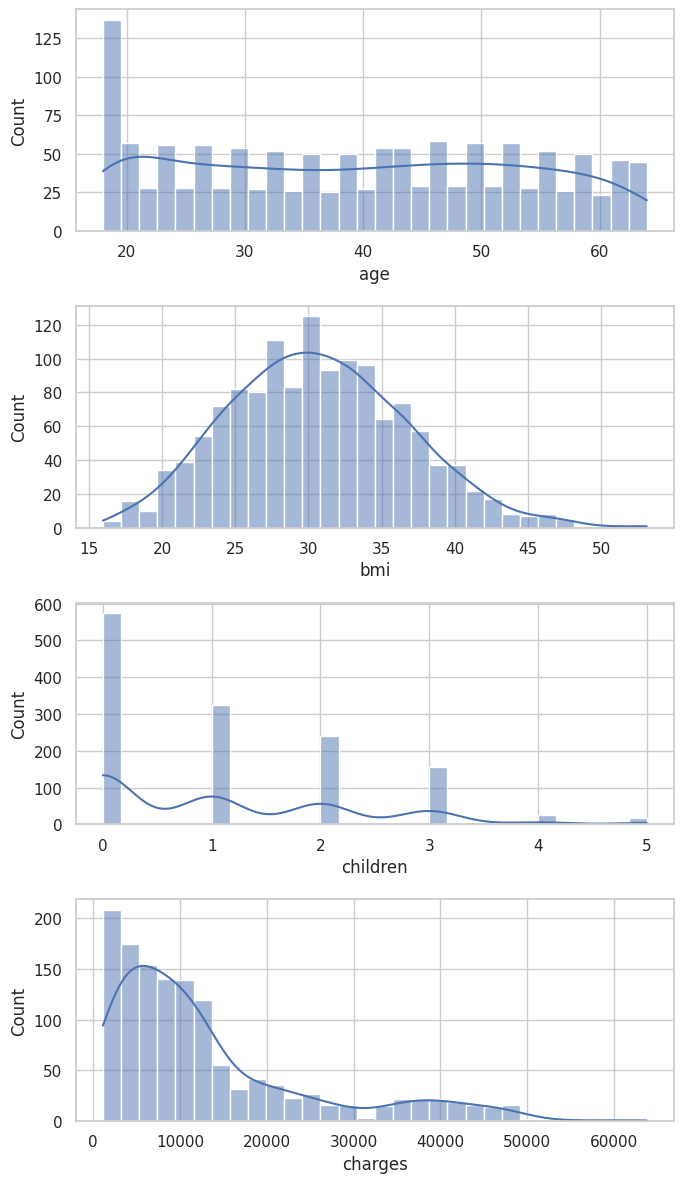

In [7]:
num_cols = ['age','bmi','children','charges']
fig, axes = plt.subplots(len(num_cols), 1, figsize=(7,12))
for ax, col in zip(axes, num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=ax)
plt.tight_layout()
plt.show()


No lets explore teh relationships between multiple facotrs.

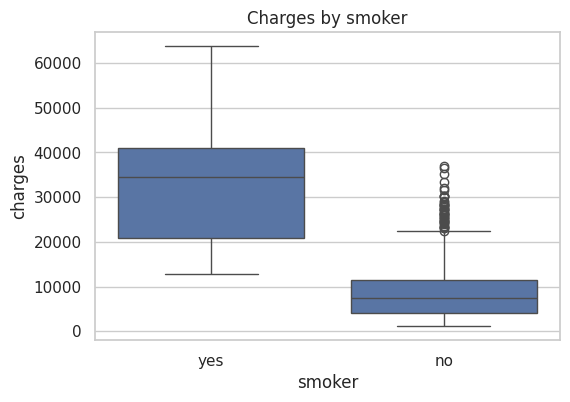

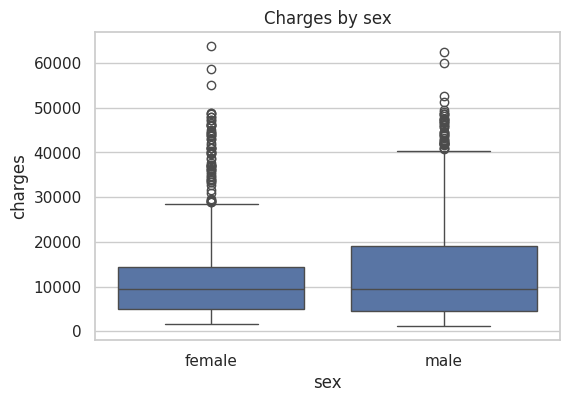

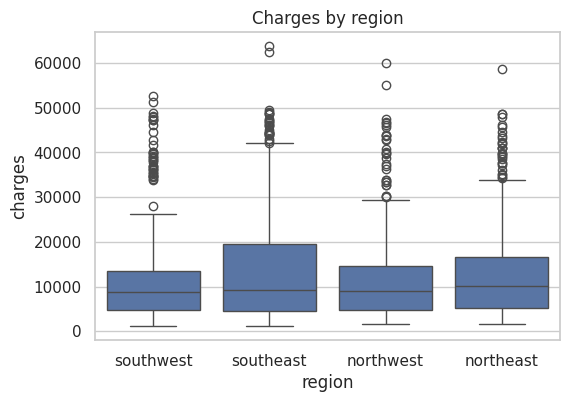

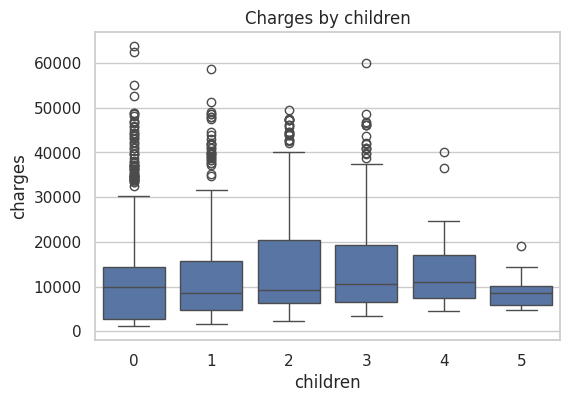

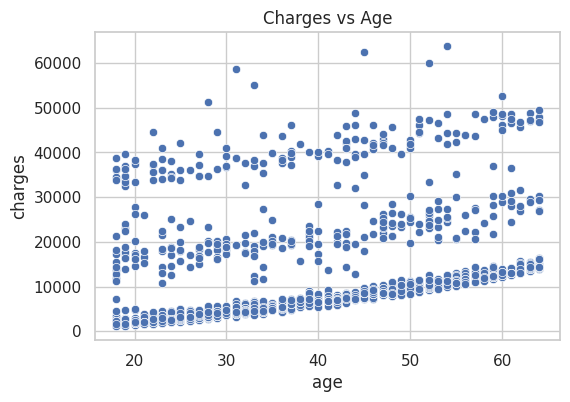

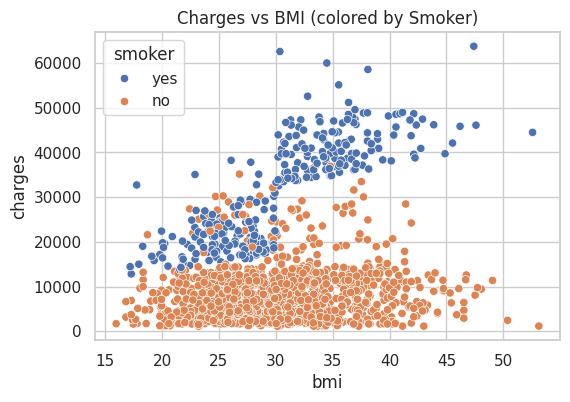

In [8]:
# Charges vs Categorical Features
for c in ['smoker','sex','region','children']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=c, y='charges', data=df)
    plt.title(f"Charges by {c}")
    plt.show()

# Scatter Plots
plt.figure(figsize=(6,4))
sns.scatterplot(x='age', y='charges', data=df)
plt.title("Charges vs Age")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title("Charges vs BMI (colored by Smoker)")
plt.show()


Summary so far:

Smokers → highest medical charges (dominant factor).

Age → strong positive correlation with cost.

Region → minor effect, mainly acts as noise.

BMI → moderate effect (especially combined with smoker).

So now, let’s turn those insights into a working machine learning model that predicts charges.


Data Preprocessing:

In [9]:
# 1️⃣ Split features & target
X = df.drop(columns=['charges'])
y = df['charges']

# 2️⃣ Identify column types
cat_cols = ['sex', 'smoker', 'region']
num_cols = ['age', 'bmi', 'children']

# 3️⃣ Train-test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Column transformer for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


Train Baseline Models:

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Pipelines
models = {
    "Linear Regression": Pipeline([('preprocessor', preprocessor),
                                   ('model', LinearRegression())]),

    "Random Forest": Pipeline([('preprocessor', preprocessor),
                               ('model', RandomForestRegressor(n_estimators=300, random_state=42))]),

    "Gradient Boosting": Pipeline([('preprocessor', preprocessor),
                                   ('model', GradientBoostingRegressor(random_state=42))])
}


Evaluate Models:

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results).sort_values('RMSE')
results_df


,Model,MAE,RMSE,R2
2,Gradient Boosting,2443.483262,4329.570011,0.879257
1,Random Forest,2553.609066,4587.882508,0.864420
0,Linear Regression,4181.194474,5796.284659,0.783593


Model Interpretation:

In [12]:
# Access the trained Gradient Boosting model
best_model = models["Gradient Boosting"]
best_model.fit(X_train, y_train)

# Retrieve feature names after preprocessing
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_features = num_cols + list(encoded_cat_cols)

# Get feature importances
importances = best_model.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Display top 10
feat_imp.head(10)


,0
smoker_yes,0.676618
bmi,0.190540
age,0.118372
children,0.010212
region_northwest,0.001726
region_southwest,0.001378
sex_male,0.000627
region_southeast,0.000526


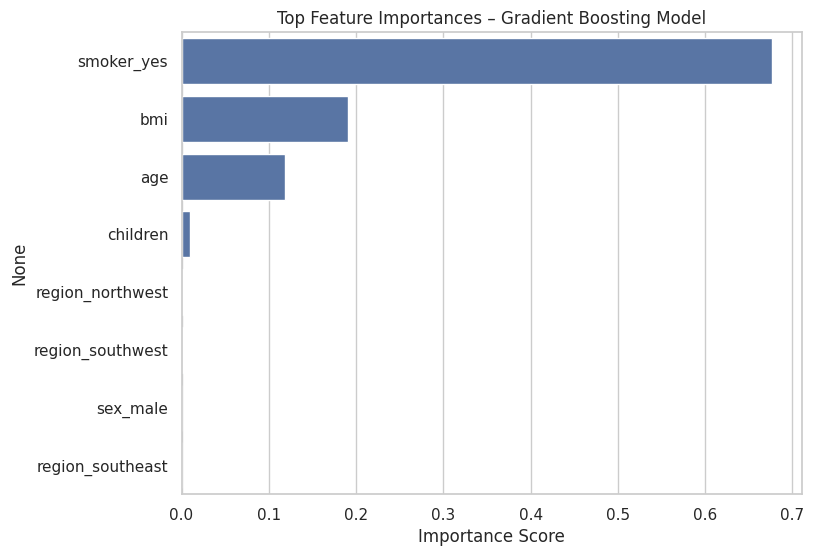

In [13]:
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(10).values, y=feat_imp.head(10).index)
plt.title("Top Feature Importances – Gradient Boosting Model")
plt.xlabel("Importance Score")
plt.show()


Save & Use the Model for Predictions:

In [14]:
import joblib

joblib.dump(best_model, "insurance_gb_model.joblib")
print("✅ Model saved!")



✅ Model saved!


Make a sample prediction:

In [15]:
example = pd.DataFrame([{
    "age": 45,
    "sex": "male",
    "bmi": 31.2,
    "children": 2,
    "smoker": "yes",
    "region": "southeast"
}])

pred = best_model.predict(example)
print(f"Predicted insurance charge: ${pred[0]:,.2f}")


Predicted insurance charge: $42,210.89
